In [2]:
library(data.table)
library("rvest")
library("stringr")
library(dplyr)
memory.size(max = T)
#install.packages("scales")
#install.packages("rlang")
#install.packages("tidyverse")
library(tidyverse)
library(caret)
library(glmnet)
library(caret)
#library(glmnet)
#install.packages("bit64")
#library("bit64")
#install.packages('lm.beta')
library("lm.beta")
library("psycho")
#install.packages("standardize")
library("standardize")

library("doParallel")
#install.packages("foreach")
#install.packages("pROC")
library("foreach")
library("pROC")

gc()


Warning message:
“'memory.size()' is Windows-specific”

[1] Inf

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2210958,118.1,3540724,189.1,3540724,189.1
Vcells,3686493,28.2,8388608,64.0,6050310,46.2


In [3]:

start_time <- Sys.time()
source("/u/project/sriram/ukbiobank/33127/bd_load_data.R")
end_time <- Sys.time()

end_time - start_time



Time difference of 2.297038 mins

In [5]:
dim(data)
str(data[,1:10])
head(data,3)

NULL

ERROR: Error in data[, 1:10]: object of type 'closure' is not subsettable


## NA filter & Treshold Value Setting

In [28]:
tr=0.25 # where the value of the "tr" depends on how strict you are on filtering out features with large observations of NA missing values.

# For tr=0.25, it means you would like to select those features whose # of missing values is smaller than 25% of its total oberservations

In [36]:

alist=as.integer(which(colSums(!is.na(data[,1:400]))>=(1-tr)*502508))

blist=as.integer(which(colSums(!is.na(data[,401:800]))>=(1-tr)*502508))
blist=blist+400

clist=as.integer(which(colSums(!is.na(data[,801:1200]))>=(1-tr)*502508))
clist=clist+800

dlist=as.integer(which(colSums(!is.na(data[,1201:1600]))>=(1-tr)*502508))
dlist=dlist+1200

elist=as.integer(which(colSums(!is.na(data[,1601:2000]))>=(1-tr)*502508))
elist=elist+1600

flist=as.integer(which(colSums(!is.na(data[,2001:2297]))>=(1-tr)*502508))
flist=flist+2000



na_free_list=c(alist,blist,clist,dlist,elist,flist)
length(na_free_list)


sum(is.na(select(data,"30000-0.0"))) 
# "30000-0.0" is the target feature corresponds to count of while blood cells. 
which(colnames(data)=="30000-0.0") #grep("30000-0.0",colnames(data))
1325 %in% na_free_list
# check to make sure you are not too strict as the cell_count feature is removed from the selected data.
# fwrite.csv(na_free_list,"na_list.csv")

[1] 773

[1] 24334

[1] 1325

[1] TRUE

## Index & Filtering Data

In [44]:
na_free_list=as.vector(na_free_list)
na_filter_data=select(data,c(na_free_list)) # filter the data based on the NA index filter 
#na_data=select(data,-c(na_free_list)) # you may also select "NA data" by adding a "-".

In [46]:
dim(na_filter_data) 
#fwrite(na_filter_data,"na_filter_data.csv") # store the data for future use.

[1] 502508    773

In [62]:
grep("30000-0.0",colnames(na_filter_data))  #405

[1] 352

In [7]:
#na_filter_data=fread("na_filter_data.csv")

In [8]:
new2=mutate(na_filter_data,count=na_filter_data$`30000-0.0`) 
# for covenience, I change the name of target feature to "count" and rename the new data as "new" 
new=select(new2,c(1:351,353:774))
grep("count",colnames(new))  #773

[1] 773

In [9]:
dim(new)

[1] 502508    773

## Numerical Data Selection

In [10]:
numeric=new %>% select_if(is.numeric) # the initial select of the numerical features


In [11]:
dim(numeric)
grep("count",colnames(numeric))

[1] 502508    548

[1] 548

In [12]:
#fwrite(numeric,"raw_numeric.csv")

## Remove the NA in Target Feature (Count)

In [92]:
new_numeric=numeric[-which(is.na(numeric$count)),]
new_numeric %>% dim

[1] 478174    548

## Missing Value Imputation with Mean

In [99]:
# use the numerical mean of each feature to impute thier NA's for all features. 
new_1=zoo::na.aggregate(new_numeric[,1:150])
new_2=zoo::na.aggregate(new_numeric[,151:300])
new_3=zoo::na.aggregate(new_numeric[,301:450])
new_4=zoo::na.aggregate(new_numeric[,451:548])
# separate the processing to avoid crash
new_impute=cbind(new_1,new_2,new_3,new_4)


In [ ]:
#fwrite(new_impute,"new_impute.csv")

In [ ]:
#colSums(is.na(new_impute[,1:30]))

In [2]:
#new_impute=fread("new_impute.csv");dim(new_impute)

In [5]:
dim(new_impute)

[1] 478174    548

## Merge the Genetic Component Data

In [14]:
new_addup_data = fread("ukb21970_select_.csv")
dim(new_addup_data)

[1] 502616     33

In [24]:
glimpse(new_addup_data)

Observations: 502,616
Variables: 33
$ eid          <int> 1000011, 1000026, 1000032, 1000044, 1000058, 1000060, 10…
$ `22009-0.1`  <dbl> -12.16240, -9.94105, -14.61760, 6.68544, -9.97432, -13.5…
$ `22009-0.10` <dbl> -0.2613310, 5.3991100, 0.5466600, 0.3143910, 0.5619040, …
$ `22009-0.11` <dbl> 3.867170, 5.376850, 2.803880, 1.766060, 0.987499, 2.2002…
$ `22009-0.12` <dbl> 2.398670, 1.606220, -3.477800, 3.475320, 1.986780, -1.51…
$ `22009-0.13` <dbl> -0.6217410, -1.6883300, -1.1080000, 0.8894040, -0.419901…
$ `22009-0.14` <dbl> 0.0486748, 0.8616980, 0.3425680, -1.7184800, 5.3925100, …
$ `22009-0.15` <dbl> -1.445240000, 1.120940000, -2.830270000, 0.428843000, -0…
$ `22009-0.16` <dbl> -2.8187500, 4.1069900, 4.2734300, 0.2038470, 0.8166950, …
$ `22009-0.17` <dbl> -0.275704, 1.415050, -1.840140, -0.225974, -0.760765, 5.…
$ `22009-0.18` <dbl> -2.072790, -2.126000, 4.122930, -1.845360, 2.357130, 1.9…
$ `22009-0.19` <dbl> 1.188470, 2.618660, 6.610140, 3.220400, -2.298460, 4.825…
$ `22009-0.20` <

In [18]:
new_m=merge(x=new_impute,y=new_addup_data,by = "eid",all.x = T)


In [19]:
#fwrite(new_m,"new_data_merge.csv")

In [32]:
dim(new_m)
grep("count",colnames(new_m)) ## the two "eid" is merged to keep only one of them. 
# the dimension 580= 33+ 548 -1 is checked correct.

[1] 478174    580

[1] 548

In [33]:
new_m$count[1:3]


[1] 8.02 3.70 4.98

## Variable Name Load for Selected Categorical Variables

In [34]:
col_name=read.csv("col_name.csv")



In [36]:
dim(col_name)
t(col_name)

[1] 482   2

X19.0.0,Dried fruit intake,Which eye(s) affected by injury or trauma resulting in loss of vision,ECG/bike method for fitness test,Which eye(s) affected by glaucoma,Current employment status - corrected,Difficulty concentrating during worst period of anxiety,Recent feelings of tiredness or low energy,Breathing problems responsible for leaving job,Cancer report format,Anaesthetics administered during delivery,⋯,41246-0.0,41247-0.0,41248-0.0,41249-0.0,41250-0.0,41251-0.0,41253-0.0,41270-0.0,41271-0.0,41272-0.0
Heel.ultrasound.method,,,,,,,,,,,⋯,Treatment speciality of consultant (recoded),Patient classification on admission (recoded),Destinations on discharge from hospital (recoded),Methods of admission to hospital (recoded),Methods of discharge from hospital (recoded),Sources of admission to hospital (recoded),Inpatient record format,Diagnoses - ICD10,Diagnoses - ICD9,Operative procedures - OPCS4


## Net Elastic 

In [44]:
use=new_m
set.seed(123)
index  <- createDataPartition(use$count, p = 0.75, list = FALSE)
train <- use[index, ]
test  <- use[-index, ]

In [48]:
grep("count",colnames(train))
grep("23098-0.0",colnames(train))
grep("30001-0.0",colnames(train)) # start the model with selected variabels selected based on beta values 

[1] 548

[1] 227

[1] 295

In [49]:
set.seed(123)
model3 <- train(
  count ~., data = train[,c(227:295,548)], method = "glmnet",
  trControl = trainControl("cv", number = 10),
  tuneLength= 10
)

In [50]:
model3$bestTune

,alpha,lambda
,<dbl>,<dbl>
41,0.5,0.0001510725


In [51]:
coef_table=coef(model3$finalModel, model3$bestTune$lambda)

In [111]:
#coef_table=as.data.frame(c(coef_table[,1]))
#print(coef_table)
coef_table_new=data.frame("variable"=rownames(coef_table),"value"=coef_table[1:70],stringsAsFactors = FALSE)

In [160]:
coef_rank=coef_table_new[coef_table_new$value>0,] # sort with decreasing order. 
coef_rank=coef_rank[order(coef_rank[,2],decreasing = T),]

In [184]:
filter_coef=as.integer(which(as.list(coef_table)>0))
filter=filter_coef-1 # select those variabels with the value greater than 0
print(filter[-1])

 [1]  2  3  4  6  7  9 12 15 18 19 20 29 31 33 34 40 41 44 47 48 49 50 52 53 54
[26] 60 62 63 64 65 66 68


In [187]:
#coef_table_new

In [189]:
train_select=train[,c(227:295,548)]
model_select=select(train_select,filter[-1])
colnames(model_select) # which corresponds UK Biobank : Data Dictionary for Application 33127




[1] "23099-0.0" "23100-0.0" "23101-0.0" "23104-0.0" "23106-0.0" "23108-0.0"
 [7] "23111-0.0" "23114-0.0" "23117-0.0" "23118-0.0" "23119-0.0" "23128-0.0"
[13] "23130-0.0" "24004-0.0" "24005-0.0" "24011-0.0" "24012-0.0" "24015-0.0"
[19] "24018-0.0" "24019-0.0" "24020-0.0" "24021-0.0" "24500-0.0" "24501-0.0"
[25] "24502-0.0" "24508-0.0" "26411-0.0" "26412-0.0" "26413-0.0" "26414-0.0"
[31] "26415-0.0" "26417-0.0"

## Remove Variables from "Blood Assays" Category

- Make sure to manually remove variables from "blood assays" category.
- To check category, click on the variable name from 3327 webpage.
- The web will lead you to the description of the specific variable(e.g. http://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=30001).
- Then click the "categories" section and inspect. 

## Manual Remove of Categorical Variables

- some of the variabels are in levels or id numbers that have been mistakenly categorized as numerical variables by R.
- need to remove them by create contigency tables to check for levels of each variable
- along with a detailed inspectation based on the ukb3327 webpage.

## Frequency Table

In [18]:
levelcount=list()
for (i in 1:ncol(new_m)){
    levelcount[i]=length(table(new_m[[i]]))
}

In [19]:
length(levelcount)

[1] 580

In [201]:
#save(levelcount,file = "var_frq.RData")

In [208]:
# Filter out levels smaller than 

In [11]:
length(which(levelcount<28))
length(which(levelcount<29))
length(which(levelcount<27))
length(which(levelcount<26))
length(which(levelcount<25))
length(which(levelcount<24))
length(which(levelcount<23))
length(which(levelcount<22))
length(which(levelcount<21))
length(which(levelcount<20))
length(which(levelcount<19))
length(which(levelcount<18))
length(which(levelcount<17))
length(which(levelcount<16))
length(which(levelcount<15))
length(which(levelcount<14))
length(which(levelcount<13))
length(which(levelcount<12))
length(which(levelcount<11))
length(which(levelcount<10))
length(which(levelcount<9))
length(which(levelcount<8))
length(which(levelcount<7))
length(which(levelcount<6))
length(which(levelcount<5))
length(which(levelcount<4))
length(which(levelcount<3))
length(which(levelcount<2))
length(which(levelcount<1))


[1] 341

[1] 342

[1] 340

[1] 337

[1] 337

[1] 336

[1] 334

[1] 334

[1] 332

[1] 332

[1] 332

[1] 332

[1] 330

[1] 329

[1] 327

[1] 326

[1] 324

[1] 321

[1] 318

[1] 313

[1] 293

[1] 275

[1] 257

[1] 210

[1] 162

[1] 135

[1] 47

[1] 45

[1] 0

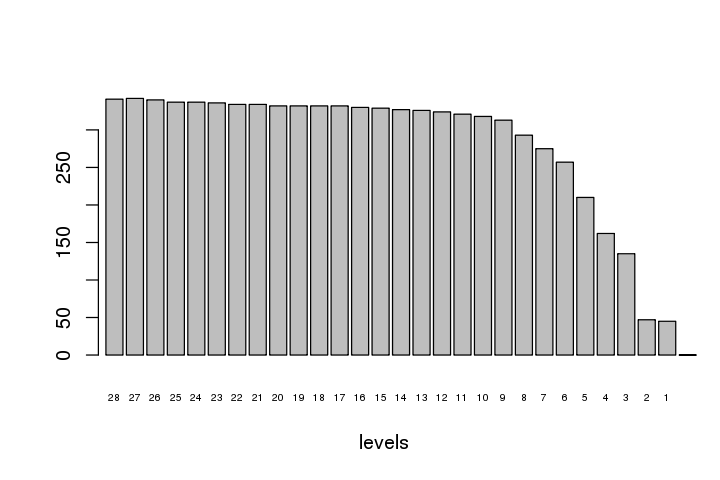

In [8]:
countlist=c(341,
342,
340,
337,
337,
336,
334,
334,
332,
332,
332,
332,
330,
329,
327,
326,
324,
321,
318,
313,
293,
275,
257,
210,
162,
135,
47,
45,
0)
options(repr.plot.width=6, repr.plot.height=4)
names(countlist)=c(28:1)
barplot(countlist,xlim = c(1,32),xlab="levels",cex.names=.5)

In [117]:
(which(levelcount==10)) # filter set at 10

select(new_m,which(levelcount==10)) %>% head()

[1]  46 178 179 186 187

1031-0.0,6141-0.0,6142-0.0,6154-0.0,6155-0.0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,-3,1,5,-7
2,1,1,-7,-7
2,1,2,5,-7
2,1,1,-7,-7
3,1,1,3,-7
1,1,1,3,-7


In [141]:
# 46,175:192,19 ,21, 39,542, 545,200,201,202,205,538,20,212,543,546,544,5,46 
#which should also be filtered out by manual inspectation

In [135]:
new_m2=new_m[,-c(46,175:192,19 ,21, 39,542, 545,200,201,202,205,538,20,212,543,546,544,5,46)]
dim(new_m2)


[1] 478174    545

## Filter Data for Based on Levels

In [136]:
levelcount=list()
for (i in 1:ncol(new_m2)){
    levelcount[i]=length(table(new_m2[[i]]))
}

In [142]:
new_m3=select(new_m2, -which(levelcount<11))

In [143]:
dim(new_m3)

[1] 478174    245

In [145]:
fwrite(new_m3,"read_for_model.csv") ## save the data 
## it's pretty clean now.

In [234]:
#fwrite(new_m,"use_june.csv")

In [14]:
#new_m=fread("use_june6.csv")

In [15]:
#levelcount=load("var_frq.RData")

In [ ]:
## here I filter out data with levels smaller 

## Scale the Data

In [149]:
scale_sample=scale(new_m3)

# use the scale function to normalize the data for regression models

In [16]:
scale_data=scale_sample
#colSums(is.infinite(scale_data))

ERROR: Error in eval(expr, envir, enclos): object 'scale_sample' not found


In [152]:
scale_data=as.data.frame(scale_data)

In [153]:
fwrite(scale_data,"ready_for_model_scaled.csv")

In [155]:
grep("count",colnames(new_m3))
dim(new_m3)

[1] 213

[1] 478174    245

In [17]:
#colSums(is.na(new_m3))

## Impute the Genetic Component Data with Mean
#### This should have been done once they were merged to the main data

In [164]:
#new_4=zoo::na.aggregate(new_numeric[,451:548])
grep("22009-0.1",colnames(new_m3))
grep("22009-0.40",colnames(new_m3))

[1] 214 215 216 217 218 219 220 221 222 223 224

[1] 245

In [167]:
dim(new_m2)
dim(new_m3)
dim(scale_data)

[1] 478174    545

[1] 478174    245

[1] 478174    245

In [168]:
new_gc_imp=zoo::na.aggregate(new_m3[,214:245])
new_others=new_m3[,1:213]

In [29]:
new_m4=cbind(new_others,new_gc_imp)
dim(new_m4)
grep("count",colnames(new_m4))
#colSums(is.na(new_m4))

ERROR: Error in cbind(new_others, new_gc_imp): object 'new_others' not found


In [173]:
## save the data ready for model
#fwrite(new_m4,"ready_for_model.csv")

In [175]:
scale_data=scale(new_m4)
dim(scale_data)
scale_data=as.data.frame(scale_data)
#fwrite(scale_data,"ready_for_model_scale.csv")

[1] 478174    245

In [177]:
new_data=scale_data

## Single Regression Models for 245 Vars

In [178]:
coeff=NULL
sum=NULL
model=NULL
r=NULL
beta=NULL
for (i in 1:245){
   
   model[[i]] <- lm(data=new_data,formula = count ~ new_data[[i]] )
   coeff[[i]]=model$coefficients
   sum[[i]]=summary(model[[i]])
    r[[i]]=sum[[i]]$adj.r.squared
    beta[[i]]=lm.beta(model[[i]])
}




Warning message in summary.lm(model[[i]]):
“essentially perfect fit: summary may be unreliable”

### More Variables Should be Removed and Reflection
- After we created the model and look at the summaries of each, a bunch of variables that were hard to be noticed by manual inspect are now showed in the summary table, especially the P-Values 

In [188]:
print(grep("30230-0.0",colnames(new_data))) # 	Nucleated red blood cell percentage #removed 
print(grep("30170-0.0",colnames(new_data))) # 	Nucleated red blood cell count # removed 
print(grep("30170-0.0",colnames(new_data))) # 	Nucleated red blood cell count # removed 
print(grep("30010-0.0",colnames(new_data))) # Red blood cell (erythrocyte) count # not here
print(grep("20004-0.0",colnames(new_data))) #	Operation code # removed
print(grep("3132-0.0",colnames(new_data)))  
print("separate")# 	453701	Text	Spirometry device serial number # removed 
grep("44-0.0",colnames(new_data)) %>% print() # 	Tape measure device ID # removed 
grep("45-0.0",colnames(new_data)) # 		Heel ultrasound device id # removed
grep("40-0.0",colnames(new_data))  %>% print()# 	ID # removed 
grep("41-0.0",colnames(new_data)) # 	ID # removed 
grep("42-0.0",colnames(new_data)) %>% print() # 	 ID # removed 
grep("43-0.0",colnames(new_data)) # 	ID # removed 
grep("36-0.0",colnames(new_data)) %>% print() # 	ID # removed 
grep("38-0.0",colnames(new_data)) # 	ID # removed 

[1] 172
[1] 166
[1] 166
[1] 150
[1] 62
[1] 59
[1] "separate"
[1] 8


[1]   9 211

[1]   4 153 163 173 187 197 204


[1] 5

[1] 6


[1] 7

[1] 22


[1]  3 43 79

In [189]:
## notes

In [192]:
#20022-0.0	#276992	Continuous	Birth weight # not here
#20007-0.0 #41697	CContinuous	Interpolated Age of participant when cancer first diagnosed not here 
#20008-0.0	#!!!!!#375034	#Continuous	Interpolated Year when non-cancer illness first diagnosed not here
#20006-0.0	#41697	Continuous	Interpolated Year when cancer first diagnosed
#3526-0.0#	298441	Integer	Mother's age at death # not here
grep("2277-0.0",colnames(new_data)) #Integer	Frequency of solarium/sunlamp use # not removed yet

# 1. recode the -10?
# 2. remove the 1568 items have value -3 (Prefer not to answer) and 4479 items have value -1 (Do not know)?
#87-0.0	#375037	Integer	Non-cancer illness year/age first occurred
#Uses data-coding 37 comprises 2 Integer-valued members in a simple list. # not here

[1] 54

In [193]:
## duplicate 
# duplicates?|
22702 ;20074 # east coordinate duplicate?
21003-0.0	#	Integer	Age when attended assessment centre ; 
21022-0.0	#502507	Integer	Age at recruitment
20075-0.0	#497545	Integer	Home location at assessment - north co-ordinate (rounded)	
22704-0.0	#502497	Integer	Home location - north co-ordinate (rounded)

[1] 22702

[1] 20074

[1] 21003

[1] 21022

[1] 20075

[1] 22704

In [194]:
grep("2149-0.0",colnames(new_data))

[1] 52

## Some interesting findings

[1]    -3 17000

    2149-0.0        
 Min.   :   -3.000  
 1st Qu.:    1.000  
 Median :    3.000  
 Mean   :    6.737  
 3rd Qu.:    7.000  
 Max.   :17000.000  

[1]    -3 17000

    2149-0.0        
 Min.   :   -3.000  
 1st Qu.:    1.000  
 Median :    3.000  
 Mean   :    6.737  
 3rd Qu.:    7.000  
 Max.   :17000.000  

.
  -3   -1    1    2    3    4    5    6    7    8    9   10   11   12   13   14 
1462 1329 7019 3185 2649 2023 1927 1516 3506  694  292 1292   87  500   46   71 
  15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30 
 452   60   20   43   14  641   23   14   10   15  217   13    5   10    3  284 
  31   32   33   34   35   36   37   40   41   42   43   45   46   48   50   51 
   1   11    6    1   58    7    3  102    2    1    2   10    2    1  147    1 
  52   53   55   60   63   65   68   70   75   76   80   82   85   90  100  104 
   2    1    4   32    1    5    1    7    6    1   26    1    1    9   60    1 
 105  110  120  125  136  150  180  197  200  250  300  350  400  450  500  600 
   1    1    5    1    1   10    1    1   17    4    6    1    4    1    2    1 
 750 1000 2000 3000 
   1    5    1    1 

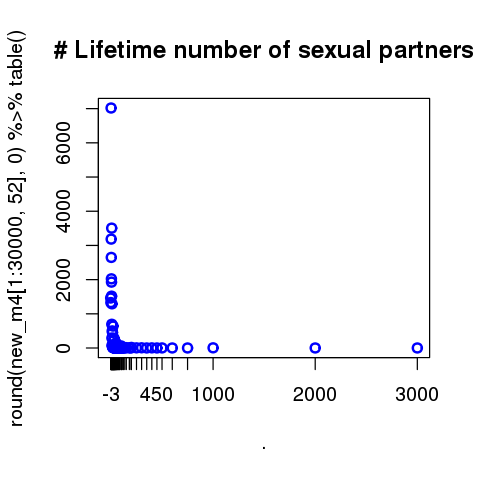

In [207]:
 #Lifetime number of sexual partners
round(new_m4[,52],0) %>% range()
round(new_m4[,52],0) %>% summary()
options(repr.plot.width=4, repr.plot.height=4)
#par(mfrow=c(2,2))
plot(round(new_m4[1:30000,52],0) %>% table(),type = "p",col="blue",main="# Lifetime number of sexual partners") 
round(new_m4[,52],0) %>% range()#Lifetime number of sexual partners
#Uses data-coding 100291 comprises 2 Integer-valued members in a simple list. # keep
round(new_m4[,52],0) %>% summary()
round(new_m4[1:30000,52],0) %>% table()

[1] 51

[1] 478174      1

[1] -3 69

    2139-0.0    
 Min.   :-3.00  
 1st Qu.:17.00  
 Median :18.00  
 Mean   :18.16  
 3rd Qu.:20.00  
 Max.   :69.00  

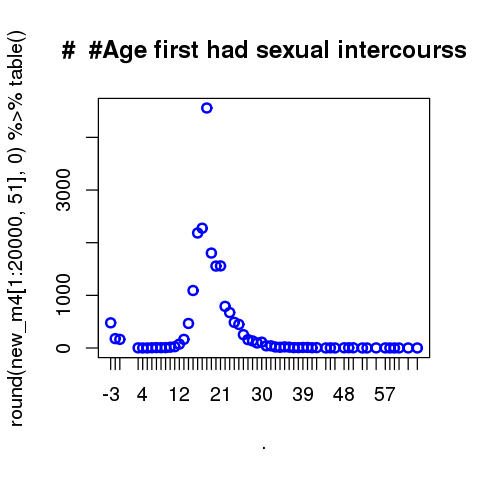

In [206]:
grep("2139-0.0",colnames(new_data))
dim(new_m4[,51]) #Age first had sexual intercourse
#Uses data-coding 100504 comprises 3 Integer-valued members in a simple list.. # keep
round(new_m4[,51],0) %>% range()
round(new_m4[,51],0) %>% summary()
plot(round(new_m4[1:20000,51],0) %>% table(),type = "p",col="blue",main="#  #Age first had sexual intercourss") 

In [213]:
new_m4[1:3,c(8,172,166,166,150, 59,9 ,211, 4 ,153, 163 ,173, 187 ,197, 204,5, 6,7, 22,3 ,43, 79)]

44-0.0,30230-0.0,30170-0.0,30170-0.0.1,30010-0.0,3132-0.0,45-0.0,41245-0.0,40-0.0,30040-0.0,⋯,30640-0.0,30740-0.0,30840-0.0,41-0.0,42-0.0,43-0.0,136-0.0,38-0.0,1438-0.0,22038-0.0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6931,0,0,0,4.072,3124,2254,1280,1178,88.66,⋯,1.065,4.669,8.55,3152,3124,1490,2,6534,25,240
4027,0,0,0,4.610,4725,2222,1160,2903,91.00,⋯,1.018,5.059,7.07,1148,4725,2766,2,1348,14,560
4539,0,0,0,4.541,3119,4321,1310,2902,94.87,⋯,1.715,4.922,12.03,1140,3119,2767,0,4563,10,360


In [215]:
new_m5=new_m4[,-c(8,172,166,166,150, 59,9 ,211, 4 ,153, 163 ,173, 187 ,197, 204,5, 6,7, 22,3 ,43, 79)]
new_scale=new_data[,-c(8,172,166,166,150, 59,9 ,211, 4 ,153, 163 ,173, 187 ,197, 204,5, 6,7, 22,3 ,43, 79)]

In [231]:
dim(new_m5)
dim(new_scale)
grep("count",colnames(new_m5))
grep("count",colnames(new_scale))
new_scale=data.frame(new_scale)

[1] 478174    224

[1] 478174    224

[1] 192

[1] 192

In [241]:
new=scale(new_m5)
new_scale=as.data.frame(new)

## By so far the cleanest data

In [248]:
dim(new_m5);dim(new_scale)

[1] 478174    224

[1] 478174    224

In [246]:
fwrite(new_m5,"ready_for_model.csv")

In [247]:
fwrite(new_scale,"ready_for_model_scale.csv")

In [3]:
new_m5=fread("ready_for_model.csv")
new_scale=fread("ready_for_model_scale.csv")

In [8]:
#cat(dim(new_scale),dim(new_m5)

## SLR Modeling with Scaled Data

In [10]:
new_data=new_scale
coeff=NULL
sum=NULL
model=NULL
r=NULL
beta=NULL
for (i in 1:224){
   
   model[[i]] <- lm(data=new_data,formula = count ~ new_data[[i]] )
   coeff[[i]]=model$coefficients
   sum[[i]]=summary(model[[i]])
    r[[i]]=sum[[i]]$adj.r.squared
    beta[[i]]=lm.beta(model[[i]])
}




Warning message in summary.lm(model[[i]]):
“essentially perfect fit: summary may be unreliable”

In [26]:
head(sort(r,decreasing = T,),10)
which(r==0.496209997371891) ## gives extradinarily high r value

[1] 1.00000000 0.49621000 0.20383409 0.06222693 0.05422961 0.04614879
 [7] 0.04210551 0.04181216 0.03387928 0.03248256

[1] 148

30120-0.0
<dbl>
0.3107822
-0.9101070
-0.3380820


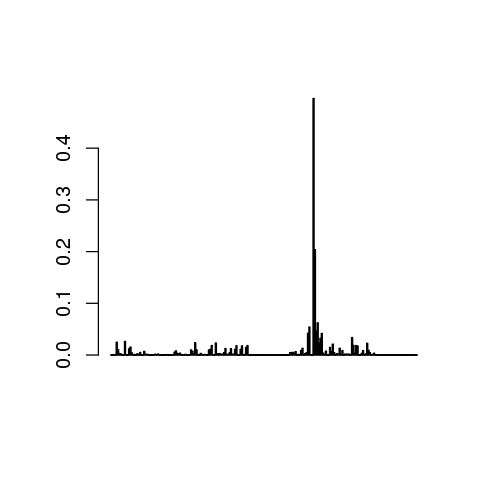

In [24]:
rr=r[-192]
options(repr.plot.width=4, repr.plot.height=4)
barplot(rr)
new_scale[1:3,148] ## we find blood assays related variables, need to remove them.

In [41]:
new_scale[1:3,c(139:191)] ## I find that 139:191 are also related with blood assays, we could remove them 
## they are the variables starts with 30xxx.0.0 

30020-0.0,30030-0.0,30050-0.0,30060-0.0,30070-0.0,30080-0.0,30090-0.0,30100-0.0,30110-0.0,30120-0.0,⋯,30780-0.0,30810-0.0,30830-0.0,30850-0.0,30860-0.0,30870-0.0,30880-0.0,30890-0.0,30897-0.0,41246-0.0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1.4954489,-1.4018767,-0.6301907,-0.3743878,0.28021224,0.5364113,1.1073603,0.6884500,-0.95777679,0.3107822,⋯,0.25041764,-0.08261698,-0.7071974,-0.8867220,0.7832685,-0.5856113,-0.8066341,-8.242190e-01,0.6946690,-0.1173369
0.1004124,0.2291841,-0.1826387,-0.2907465,-0.49935561,-0.1330565,-0.5044909,-0.7678099,0.01844971,-0.9101070,⋯,0.07514189,-1.03831426,-0.9507722,-0.9165314,-0.6696328,0.6096911,-0.7684892,3.405956e-01,-0.1351576,-0.4401243
0.5174214,0.5638328,0.6135873,-0.1141706,0.08785134,-1.7800805,-1.3818276,1.8221207,1.66463557,-0.3380820,⋯,3.00777576,-0.12243770,2.0509975,1.2482008,0.4349880,0.3618724,-0.8002766,7.043834e-16,0.3849961,-0.1173369


## Remove "Blood Assays" Categories of Variables 
- Those variables usually start with with 30xxx.0.0 

In [42]:
new_m6=new_m5[,-c(139:191)]
new_scale2=new_scale[,-c(139:191)]

In [45]:
dim(new_m6)
dim(new_scale2)

[1] 478174    171

[1] 478174    171

In [46]:
## save the new data:
fwrite(new_m6,"ready_for_model_bs.csv")
fwrite(new_scale2,"ready_for_model_scale_bs.csv")

## SLR Modeling with Scaled Data again after "blood assays" Vars Removved

In [48]:
new_data=new_scale2
coeff=NULL
sum=NULL
model=NULL
r=NULL
beta=NULL
for (i in 1:171){
   
   model[[i]] <- lm(data=new_data,formula = count ~ new_data[[i]] )
   coeff[[i]]=model$coefficients
   sum[[i]]=summary(model[[i]])
    r[[i]]=sum[[i]]$adj.r.squared
    beta[[i]]=lm.beta(model[[i]])
}





Warning message in summary.lm(model[[i]]):
“essentially perfect fit: summary may be unreliable”

In [49]:
grep("count",colnames(new_scale2))

[1] 139

[1]   5  11  62  77 139

48-0.0,102-0.0,21001-0.0,23104-0.0,count
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.9140944,-0.9373058,-0.7111549,-0.7232506,0.5346595
-0.6908929,0.8359927,1.0498879,1.0566559,-1.5004576
0.6483163,-1.2919655,-0.2661924,-0.2782740,-0.8974599


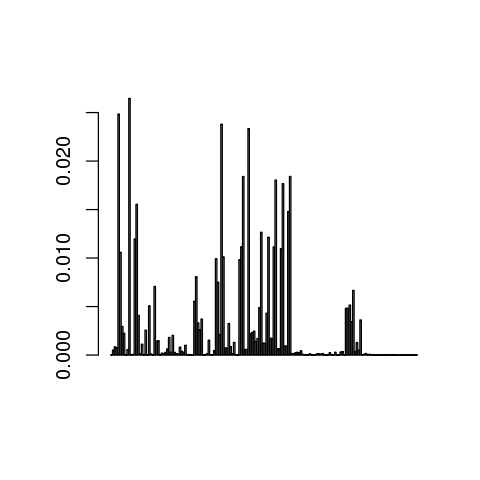

In [52]:
options(repr.plot.width=4, repr.plot.height=4)
barplot(r[-139])
which(r>=0.02)
new_scale2[1:3,c(5 ,11 ,62, 77, 139)]





## high R^2 variables with count
- Waist circumference
- Pulse rate, automated reading
- Body mass index (BMI) !!! we remove 77 because it duplicates with 139, this one is integer
- Body mass index (BMI) 

## Remove duplicated BMI Variable 77



In [54]:
new_m7=new_m6[,-77]
new_scale3=new_scale2[,-77]

In [55]:
## save the new data:
fwrite(new_m7,"ready_for_model_bs2.csv")
fwrite(new_scale3,"ready_for_model_scale_bs2.csv")

In [2]:
start_time <- Sys.time()

new_m7=fread("ready_for_model_bs2.csv")
new_scale3=fread("ready_for_model_scale_bs2.csv")
end_time <- Sys.time()
end_time-start_time

Time difference of 12.77539 secs

## Beta Value (correlations)

In [3]:
grep("count",colnames(new_scale3))

[1] 138

In [4]:
new_data=new_scale3 # remember to change variable names here each time you remove variables
coeff=NULL
sum=NULL
model=NULL
r=NULL
beta=NULL
for (i in 1:170){ # remember to change index
   
   model[[i]] <- lm(data=new_data,formula = count ~ new_data[[i]] )
   coeff[[i]]=model$coefficients
   sum[[i]]=summary(model[[i]])
    r[[i]]=sum[[i]]$adj.r.squared
    beta[[i]]=lm.beta(model[[i]])
}





new_beta=NULL
for (i in 1:170){
    new_beta[[i]]=abs(beta[[i]]$`coefficients`[2])
}

Warning message in summary.lm(model[[i]]):
“essentially perfect fit: summary may be unreliable”

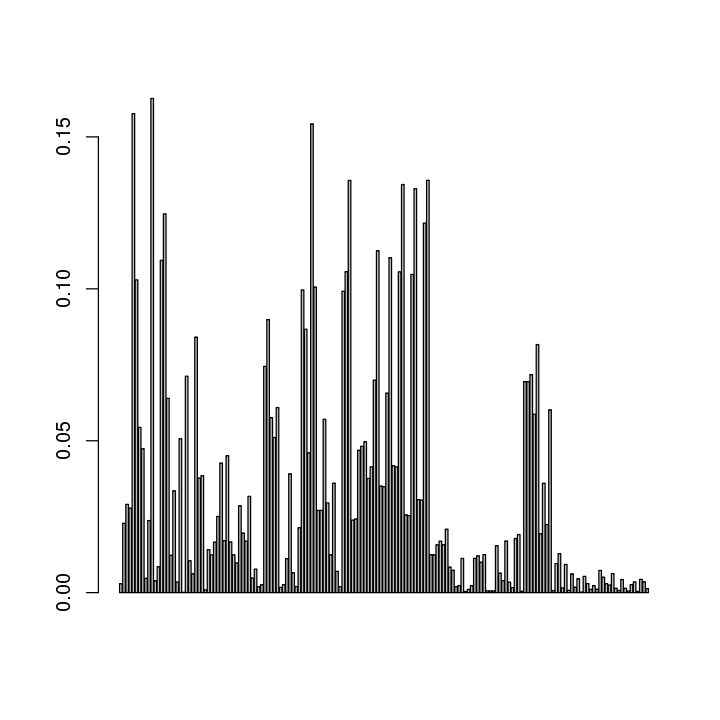

In [9]:
options(repr.plot.width=6, repr.plot.height=6)
barplot(new_beta[-138])

## Try Modeling with Non-Scaled Data

Warning message in summary.lm(model[[i]]):
“essentially perfect fit: summary may be unreliable”

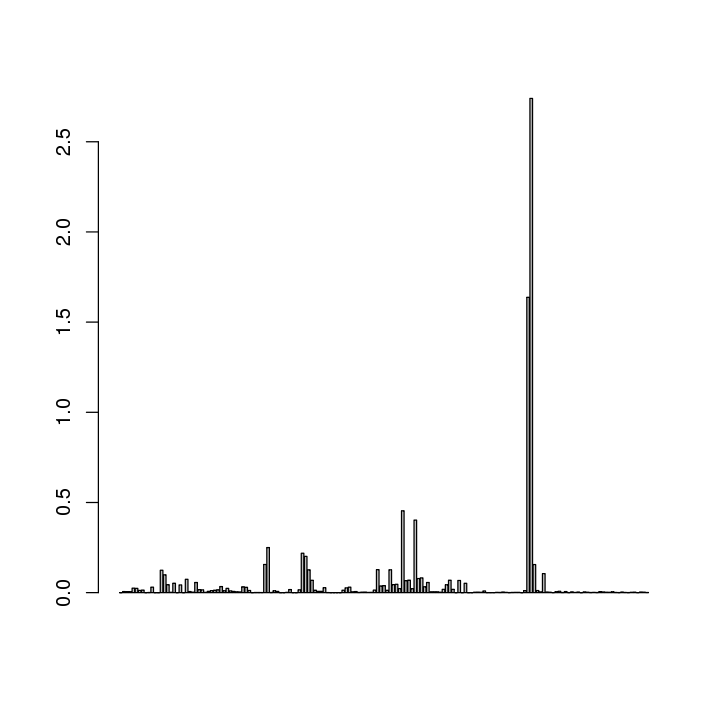

In [10]:
new_data=new_m7 # remember to change variable names here each time you remove variables
coeff=NULL
sum=NULL
model=NULL
r=NULL
beta=NULL
for (i in 1:170){ # remember to change index
   
   model[[i]] <- lm(data=new_data,formula = count ~ new_data[[i]] )
   coeff[[i]]=model$coefficients
   sum[[i]]=summary(model[[i]])
    r[[i]]=sum[[i]]$adj.r.squared
    beta[[i]]=lm.beta(model[[i]])
}





new_beta=NULL
for (i in 1:170){
    new_beta[[i]]=abs(beta[[i]]$`coefficients`[2])
}
options(repr.plot.width=6, repr.plot.height=6)
barplot(new_beta[-138])

In [14]:
which(new_beta>=0.4)
new_m7[1:3,c(91,95,131,132,138)]

[1]  91  95 131 132 138

23120-0.0,23124-0.0,26411-0.0,26412-0.0,count
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.0,1.0,0.06,0.09,8.02
1.9,2.0,0.16,0.13,3.70
1.2,1.2,0.02,0.04,4.98


##  MLR with Non-Scaled Data

In [17]:
#non scale
model_MLR <- lm(data=new_m7,formula = count ~ . - new_m7$count)

In [18]:
summary(model_MLR)


Call:
lm(formula = count ~ . - new_m7$count, data = new_m7)

Residuals:
   Min     1Q Median     3Q    Max 
 -8.34  -1.15  -0.19   0.92 382.99 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -2.294e+02  2.646e+01  -8.671  < 2e-16 ***
eid          -4.435e-09  2.022e-09  -2.194 0.028230 *  
`34-0.0`      1.075e-01  4.075e-03  26.382  < 2e-16 ***
`46-0.0`      1.295e-03  6.318e-04   2.051 0.040304 *  
`47-0.0`      3.900e-03  6.308e-04   6.183 6.31e-10 ***
`48-0.0`      2.701e-02  5.915e-04  45.654  < 2e-16 ***
`49-0.0`     -1.697e-02  7.794e-04 -21.772  < 2e-16 ***
`50-0.0`     -2.694e-02  2.495e-03 -10.800  < 2e-16 ***
`51-0.0`     -3.635e-03  8.221e-04  -4.422 9.78e-06 ***
`92-0.0`     -6.442e-06  3.702e-06  -1.740 0.081843 .  
`96-0.0`     -1.083e-04  5.286e-05  -2.049 0.040421 *  
`102-0.0`     2.453e-02  2.815e-04  87.143  < 2e-16 ***
`129-0.0`    -2.343e-08  2.579e-08  -0.908 0.363650    
`130-0.0`    -2.201e-08  3.865e-08  -0.569 0.569141    


### R-squared:  0.08717

## Multivariable Linear Regression with Scaled Data

In [42]:
## scale 

model_MLR_scale <- lm(data=new_scale3,formula = count ~ . - new_scale3$count)

In [10]:
#print(summary(model_MLR_scale))

### Adjusted R-squared:  0.08717 

## with a smaller residual standard error
### rmse 0.9554

In [77]:
#identical(new_data,new_scale3)

[1] FALSE

## SLR Modeling with NON-Scaled Data 

In [60]:
new_data=new_m7
coeff=NULL
sum=NULL
model=NULL
r=NULL
beta=NULL
for (i in 1:170){
   
   model[[i]] <- lm(data=new_data,formula = count ~ new_data[[i]] )
   coeff[[i]]=model$coefficients
   sum[[i]]=summary(model[[i]])
    r[[i]]=sum[[i]]$adj.r.squared
    beta[[i]]=lm.beta(model[[i]])
}
new_beta=NULL
for (i in 1:170){
    new_beta[i]=abs(beta[[i]]$`standardized.coefficients`[2])
}





Warning message in summary.lm(model[[i]]):
“essentially perfect fit: summary may be unreliable”

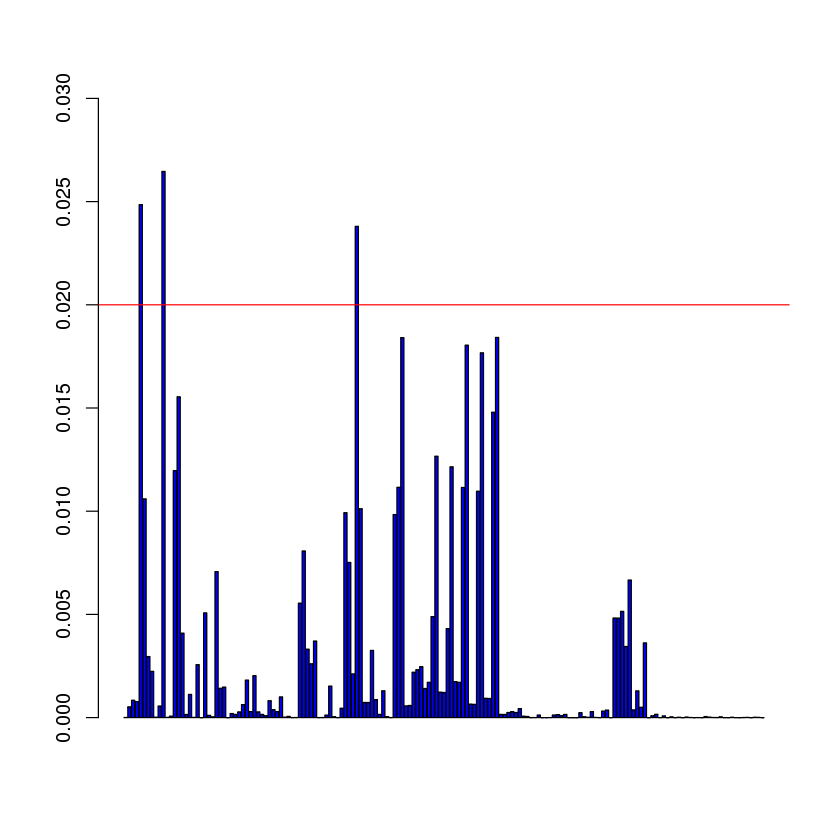

In [73]:
barplot(r[-138],col="blue",ylim=c(0,0.03))
abline(h = 0.02,col="red")

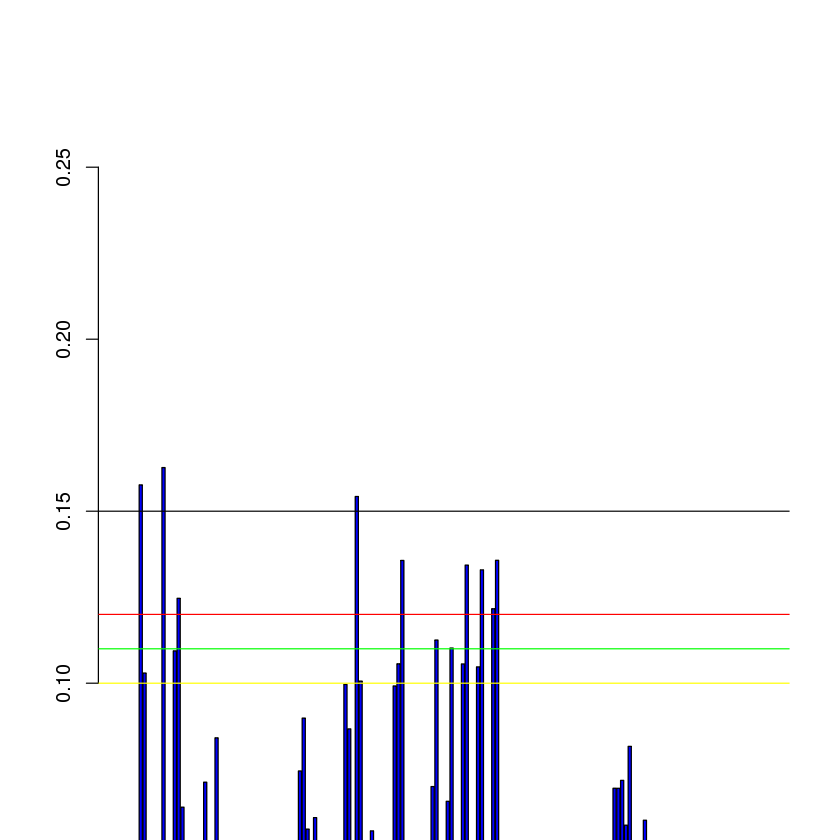

In [74]:
barplot(new_beta[-138],ylim=c(0.09,0.27),col="blue")
abline(h = 0.15,col="black")
abline(h = 0.12,col="red")
abline(h = 0.10,col="yellow")
abline(h = 0.11,col="green")

In [75]:
which(new_beta>=0.12)

[1]   5  11  15  62  74  91  95  98  99 138

In [76]:
new_sample_beta=new_m7 %>% select(.,which(new_beta>=0.12)) 
print(colnames(new_sample_beta))
## the variables in bold are in great chance to be highly correlated with while blood cell count

 [1] "48-0.0"    "102-0.0"   "137-0.0"   "21001-0.0" "23100-0.0" "23120-0.0"
 [7] "23124-0.0" "23127-0.0" "23128-0.0" "count"    


- **Waist circumference**
- **Pulse rate**
- **Number of treatments/medications taken**
- *Body mass index (BMI)*
- **Whole body fat mass**
- > *Body mass index (BMI) integer*

-------------------------------------
- *Arm fat mass (right)*
- *Arm fat mass (left)*
- *Trunk fat percentage*
- *Trunk fat mass*
- > Platelet count
- > Platelet crit

-------------------------------------
- > Eosinophill count
- > Basophill count
- > Lymphocyte percentage
- > Monocyte percentage
- > Neutrophill percentage
- > Immature reticulocyte fraction

-------------------------------------
- > High light scatter reticulocyte count
- > C-reactive protein
- > Cystatin C
- > Glycated haemoglobin (HbA1c)
- > HDL cholesterol
- > Triglycerides

-------------------------------------
- Count




## Be Aware of the High Correlation

In [65]:
cor(new_data$`23112-0.0`[1:100],new_data$`23116-0.0`[1:100]) # left arm, left leg 

[1] 0.9866436

In [66]:
#cor(new_data$`21001-0.0`[1:100],new_data$`23104-0.0`[1:100])

In [67]:
#cor(new_data$`23100-0.0`[1:100],new_data$`23104-0.0`[1:100])

In [68]:
#cor(new_data$`21001-0.0`[1:100],new_data$`23104-0.0`[1:100])

In [69]:
cor(new_data$`23120-0.0`[1:100],new_data$`23124-0.0`[1:100]) # left arm, right arm

[1] 0.9940597

In [70]:
cor(new_data$`23100-0.0`[1:100],new_data$`23128-0.0`[1:100]) # whole body mass \, trunk mass

[1] 0.9034491

In [71]:
cor.test(new_data$`135-0.0`[1:300],new_data$`137-0.0`[1:300]);cor.test(new_data$`48-0.0`[1:100],new_data$`49-0.0`[1:100])
## these two are fine to be included


	Pearson's product-moment correlation

data:  new_data$`135-0.0`[1:300] and new_data$`137-0.0`[1:300]
t = 11.828, df = 298, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4828966 0.6376551
sample estimates:
      cor 
0.5652286 



	Pearson's product-moment correlation

data:  new_data$`48-0.0`[1:100] and new_data$`49-0.0`[1:100]
t = 8.695, df = 98, p-value = 8.166e-14
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5325281 0.7580760
sample estimates:
      cor 
0.6599198 


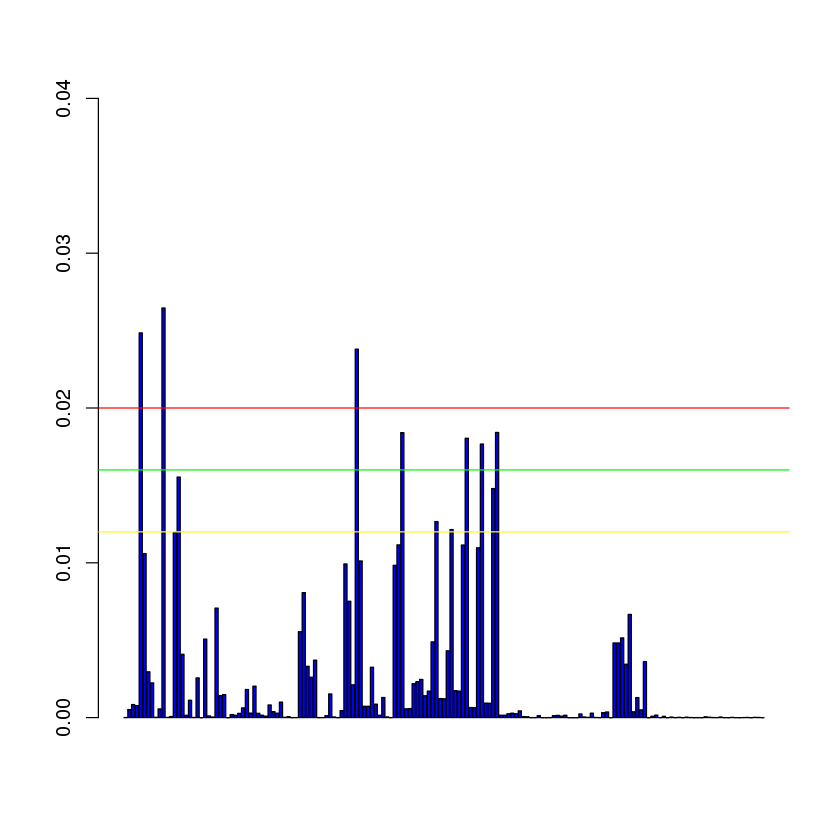

In [78]:
barplot(r[-138],col="blue",ylim=c(0,0.04))
abline(h = 0.02,col="red")
abline(h = 0.016,col="green")
abline(h = 0.012,col="yellow")

## Glmnet and other regulations L1,L2


In [81]:
new_data=new_scale3
coeff=NULL
sum=NULL
model=NULL
r=NULL
beta=NULL
for (i in 1:170){
   
   model[[i]] <- lm(data=new_data,formula = count ~ new_data[[i]] )
   coeff[[i]]=model$coefficients
   sum[[i]]=summary(model[[i]])
    r[[i]]=sum[[i]]$adj.r.squared
    beta[[i]]=lm.beta(model[[i]])
}
new_beta=NULL
for (i in 1:170){
    new_beta[i]=abs(beta[[i]]$`standardized.coefficients`[2])
}






Warning message in summary.lm(model[[i]]):
“essentially perfect fit: summary may be unreliable”

In [82]:
registerDoParallel(cores = 4)

### sample some data for faster modelling

In [101]:
set.seed(123) ## keep the seed uniform each time
new_new=new_scale3[sample(1:nrow(new_data),50000,replace = F),]
n=nrow(new_new)
sample <- sample(seq(n), size = n * 0.5, replace = FALSE)
training.samples <- new_new$count %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data  <- new_new[training.samples, ]
test.data <- new_new[-training.samples, ]
# Predictor variables
x <- model.matrix(count~., train.data)[,-1]
# Outcome variable
y <- train.data$count
dim(new_new)

[1] 50000   170

In [102]:
lasso=glmnet(x, y, alpha = 1, lambda = NULL)
ridge=glmnet(x, y, alpha = 0, lambda = NULL)

In [103]:
set.seed(123) 
cv.ridge <- cv.glmnet(x, y, alpha = 0)
# Display the best lambda value
cv.ridge$lambda.min

[1] 0.01668565

In [104]:
# Fit the final model on the training data
model.ridge <- glmnet(x, y, alpha = 0, lambda = cv.ridge$lambda.min)
# Display regression coefficients
head(sort(coef(model.ridge),decreasing = T),10)

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient


[1] 0.15926029 0.13182930 0.12597671 0.06628244 0.05068506 0.04759833
 [7] 0.04405598 0.04172301 0.04074601 0.03975098

In [105]:
which(coef(model.ridge)==0) ## none coef is coerced to zero 

integer(0)

In [106]:
# Make predictions on the test data
x.test <- model.matrix(count ~., test.data)[,-1]
predictions <- model.ridge %>% predict(x.test) %>% as.vector()
# Model performance metrics
data.frame(
  RMSE = RMSE(predictions, test.data$count),
  Rsquare = R2(predictions, test.data$count)
)

RMSE,Rsquare
<dbl>,<dbl>
0.9372578,0.08842417


### RMSE = 0.9372578 for Ridge 
- smaller than that of the MLR model for Scaled Data

In [93]:
## When making alpha =1, for lasso
set.seed(123) 
cv.ridge <- cv.glmnet(x, y, alpha = 1)
# Display the best lambda value
cv.ridge$lambda.min
# Fit the final model on the training data
model.ridge <- glmnet(x, y, alpha = 1, lambda = cv.ridge$lambda.min)
# Display regression coefficients
head(sort(coef(model.ridge),decreasing = T),10)
# Make predictions on the test data
x.test <- model.matrix(count ~., test.data)[,-1]
predictions <- model.ridge %>% predict(x.test) %>% as.vector()
# Model performance metrics
data.frame(
  RMSE = RMSE(predictions, test.data$count),
  Rsquare = R2(predictions, test.data$count)
)

[1] 0.0008304487

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient


[1] 0.21109365 0.17144672 0.15385079 0.13297862 0.09329971 0.07212175
 [7] 0.06742440 0.05056084 0.03844347 0.03656213

RMSE,Rsquare
<dbl>,<dbl>
0.9371335,0.08866836


### RMSE = 0.9371335 for lasso 

#### rmse: Lasso < Ridge < MLR 
#### Laso also helps with variable selection


In [96]:
which(coef(model.ridge)==0) ## lasso has penalize the feature coef to zero 

[1]  15  41  46  48  54  58  60  63  64  71  73  76  77  78  79  83  85  86  88
[20]  90  93  95  97  98 104 105 112 113 118 119 120 121 125 129 131 146 153 156
[39] 158 162 166 169

#### Note that by default, the function glmnet() standardizes variables so that their scales are comparable. However, the coefficients are always returned on the original scale.




## Tune best Alpha and Lamda

In [117]:
# Build the model using the training set
set.seed(123)
model.ela <- train(
  count ~., data = train.data, method = "glmnet",
  trControl = trainControl("cv", number = 10),
  tuneLength = 10
)
# Best tuning parameter
model.ela$bestTune

Warning message in mclapply(argsList, FUN, mc.preschedule = preschedule, mc.set.seed = set.seed, :
“scheduled cores 1, 3 did not deliver results, all values of the jobs will be affected”

,alpha,lambda
,<dbl>,<dbl>
34,0.8,0.0009504264


In [113]:
#t8 84	0.9	0.0009504264


,alpha,lambda
,<dbl>,<dbl>
84,0.9,0.0009504264


In [116]:
t5 # 74	0.8	0.0009504264


,alpha,lambda
,<dbl>,<dbl>
74,0.8,0.0009504264


In [119]:
model.best.ela <- glmnet(x, y, alpha = 0.8, lambda = 0.0009504264)
# Dsiplay regression coefficients
head(sort(coef(model.best.ela),decreasing = T),10)

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient


[1] 0.22464858 0.17123942 0.16035510 0.13310816 0.08574627 0.07603811
 [7] 0.06750093 0.05071756 0.03853983 0.03794080

In [120]:
# Make predictions on the test data
x.test <- model.matrix(count ~., test.data)[,-1]
predictions <- model.best.ela %>% predict(x.test) %>% as.vector()
# Model performance metrics
data.frame(
  RMSE = RMSE(predictions, test.data$count),
  Rsquare = R2(predictions, test.data$count)
)

RMSE,Rsquare
<dbl>,<dbl>
0.9370821,0.08876383


### now the RMSE 0.9370821
### Rsquare 0.08876383

In [123]:
#?R2()

In [137]:

beta_net_ela=cbind(as.data.frame(x=colnames(x),stringsAsFactors = F),as.data.frame(x=as.vector(model.best.ela$beta)))
colnames(beta_net_ela)=c("variable","beta")


In [142]:
removed_var=beta_net_ela[abs(beta_net_ela$beta)==0,]
glmnet_var=beta_net_ela[abs(beta_net_ela$beta)>0,]

In [145]:
removed_var[,1]

[1] "`135-0.0`"    "`1873-0.0`"   "`2277-0.0`"   "`3062-0.0`"   "`20010-0.0`" 
 [6] "`20075-0.0`"  "`20256-0.0`"  "`21001-0.0`"  "`21002-0.0`"  "`22702-0.0`" 
[11] "`23098-0.0`"  "`23101-0.0`"  "`23102-0.0`"  "`23106-0.0`"  "`23107-0.0`" 
[16] "`23113-0.0`"  "`23114-0.0`"  "`23116-0.0`"  "`23118-0.0`"  "`23121-0.0`" 
[21] "`23123-0.0`"  "`23125-0.0`"  "`23126-0.0`"  "`24005-0.0`"  "`24012-0.0`" 
[26] "`24013-0.0`"  "`24019-0.0`"  "`24020-0.0`"  "`24021-0.0`"  "`24022-0.0`" 
[31] "`24503-0.0`"  "`24507-0.0`"  "`26410-0.0`"  "`22009-0.16`" "`22009-0.26`"
[36] "`22009-0.28`" "`22009-0.32`" "`22009-0.36`" "`22009-0.39`"

In [148]:
glmnet_var[order(glmnet_var$beta,decreasing = T),] %>% head(.,30)

,variable,beta
,<chr>,<dbl>
2,`34-0.0`,0.22464858
5,`48-0.0`,0.17123942
64,`21003-0.0`,0.16035510
11,`102-0.0`,0.13310816
74,`23100-0.0`,0.08574627
90,`23119-0.0`,0.07603811
15,`137-0.0`,0.06750093
51,`4080-0.0`,0.05071756
61,`20258-0.0`,0.03853983


1. Year of birth
2. Waist circumference
3. Age when attended assessment centre
4. Pulse rate, automated reading
5. Whole body fat mass
6. Arm fat percentage
7. Townsend deprivation index at recruitment
8. Systolic blood pressure, automated reading
9. FEV1/ FVC ratio Z-score
10. Impedance of leg (left)
11. Townsend deprivation index at recruitment
12. Trunk fat mass
13. Time spent watching television
14. Forced vital capacity (FVC) Z-score
15. Traffic intensity on the nearest major road
16. Income score (England)
17. Body fat percentage
18. Trunk fat-free mass
19. Nitrogen dioxide air pollution; 2007
20. Hand grip strength 
21. Education score (England)
22. Sitting height
23. Time spent using computer
24. Place of birth in UK - north co-ordinate
25. Duration of moderate activity
26. Tea intake
27. Acceptability of each blow result
28. Time spend outdoors in summer
29. Age started wearing glasses or contact lenses
30. Greenspace percentage, buffer 1000m

## Adjust R Square Values

In [152]:
r_square=(cbind(as.character(names(new_scale3)),r))
colnames(r_square)=c("variable","adj-r")
r_square=as.data.frame(r_square,stringsAsFactors = F)
dim(r_square)


[1] 170   2

In [153]:
r_square$`adj-r`=as.double(r_square$`adj-r`)
head(r_square)
range(r_square$`adj-r`)
which(r_square$`adj-r`<0)
r_square[c(which(r_square$`adj-r`<0)),]

variable,adj-r
<chr>,<dbl>
eid,6.743052e-06
34-0.0,5.192070e-04
46-0.0,8.421712e-04
47-0.0,7.720492e-04
48-0.0,2.485185e-02
49-0.0,1.059631e-02


[1] -2.076157e-06  1.000000e+00

[1]  21  28 111 112 118 119 120 129 140 145 149 152 154 161 164 167 170

,variable,adj-r
,<chr>,<dbl>
21,894-0.0,-2.076157e-06
28,1160-0.0,-1.245293e-06
111,24012-0.0,-1.941821e-06
112,24013-0.0,-9.283905e-07
118,24020-0.0,-1.744890e-06
119,24021-0.0,-1.742160e-06
120,24022-0.0,-1.745138e-06
129,24508-0.0,-1.879992e-06
140,22009-0.10,-1.620699e-06


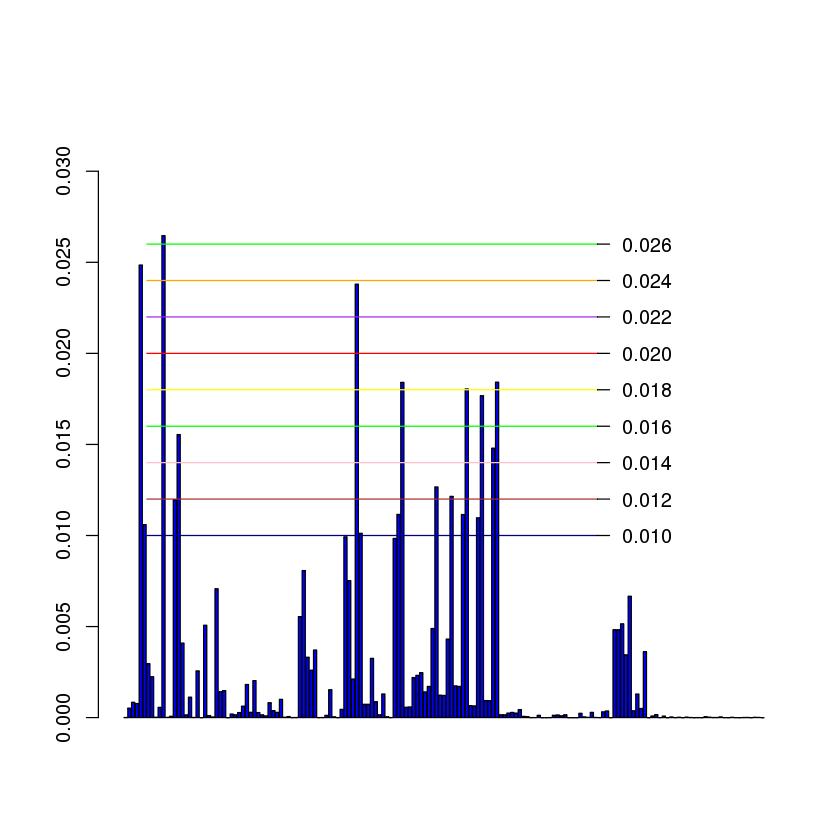

In [155]:
barplot(r_square$`adj-r`[-138],col="blue",ylim=c(0,0.034),horiz = F)
par(mar=c(5,6,10,10)+.1)
abline(h = 0.026,col="green")
abline(h = 0.024,col="orange")
abline(h = 0.022,col="purple")
abline(h = 0.020,col="red")
abline(h = 0.018,col="yellow")
abline(h = 0.016,col="green")
abline(h = 0.014,col="pink")
abline(h = 0.012,col="brown")
abline(h = 0.010,col="navy")
axis(4, at=0.026,labels=0.026,las=2)
axis(4, at=0.024,labels=0.024,las=2)
axis(4, at=0.022,labels=0.022,las=2)
axis(4, at=0.020,labels="0.020",las=2)
axis(4, at=0.018,labels=0.018,las=2)
axis(4, at=0.016,labels=0.016,las=2)
axis(4, at=0.014,labels=0.014,las=2)
axis(4, at=0.012,labels=0.012,las=2)
axis(4, at=0.0100,labels="0.010",las=2)

In [156]:

which(r_square$`adj-r`>=0.026 & r_square$`adj-r` < 1 ) %>% print()
which(r_square$`adj-r` >= 0.024 & r_square$`adj-r` < 0.026) %>% print()
which(r_square$`adj-r` >= 0.022 & r_square$`adj-r` < 0.024) %>% print()
which(r_square$`adj-r` >= 0.020 & r_square$`adj-r` < 0.022) %>% cat("[1] None" ,.,"\n")
which(r_square$`adj-r` >= 0.018 & r_square$`adj-r` < 0.020) %>% print()
which(r_square$`adj-r` >= 0.016 & r_square$`adj-r` < 0.018) %>% print()
which(r_square$`adj-r` >= 0.014 & r_square$`adj-r` < 0.016) %>% print()
which(r_square$`adj-r` >= 0.012 & r_square$`adj-r` < 0.014) %>% print()
which(r_square$`adj-r` >= 0.010 & r_square$`adj-r` < 0.012) %>% print()

[1] 11
[1] 5
[1] 62
[1] None  
[1] 74 91 99
[1] 95
[1] 15 98
[1] 83 87
[1]  6 14 63 73 90 94


In [4]:
dim(new_m7)

[1] 478174    170

## Select Categorical Data 

In [3]:
cate=fread("white_cate.csv")

In [6]:
dim(cate)

[1] 440548      9

In [7]:
sapply(cate[,-c(1,8,9)],table)

$`31-0.0`

     0      1 
241058 199490 

$`1239-0.0`

    -3      0      2 
   389 427127  13032 

$`1249-0.0`

    -3      1      2      3      4 
  1860 115440  62521  69705 191022 

$`1558-0.0`

    -3      1      2      3      4      5      6 
   451  87708 104211 115213  48640  49415  34910 

$`6150-0.0`

    -7     -3      1      2      3      4 
308140   1071   9757   9815   5160 106605 

$`21000-0.0`

    -3     -1      1      2      3      4      5      6   1001   1002   1003 
  1391    177    467     38     32     20   1395   3897 389994  11216  14114 
  2001   2002   2003   2004   3001   3002   3003   3004   4001   4002   4003 
   481    335    688    851   5337   1565    174   1586   3708   2987     95 


In [8]:
# inspect the data 
colSums(is.na(cate))

eid    31-0.0  1239-0.0  1249-0.0  1558-0.0  6150-0.0 21000-0.0 30000-0.0 
        0         0         0         0         0         0         0         0 
30010-0.0 
        0

## Modelling with Categorial Data

In [9]:
new_cate_data_white=cate
model_1=lm(data=new_cate_data_white[,-9], formula = new_cate_data_white$`30000-0.0`~factor(new_cate_data_white$`31-0.0`)+factor(new_cate_data_white$`1239-0.0`)+factor(new_cate_data_white$`1249-0.0`)+factor(new_cate_data_white$`1558-0.0`)+factor(new_cate_data_white$`6150-0.0`)+factor(new_cate_data_white$`21000-0.0`))

In [10]:
model_cate_1=model_1
summary(model_cate_1)


Call:
lm(formula = new_cate_data_white$`30000-0.0` ~ factor(new_cate_data_white$`31-0.0`) + 
    factor(new_cate_data_white$`1239-0.0`) + factor(new_cate_data_white$`1249-0.0`) + 
    factor(new_cate_data_white$`1558-0.0`) + factor(new_cate_data_white$`6150-0.0`) + 
    factor(new_cate_data_white$`21000-0.0`), data = new_cate_data_white[, 
    -9])

Residuals:
   Min     1Q Median     3Q    Max 
 -7.14  -1.15  -0.19   0.92 382.91 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                  7.231560   0.135302  53.447
factor(new_cate_data_white$`31-0.0`)1       -0.011656   0.006383  -1.826
factor(new_cate_data_white$`1239-0.0`)0     -0.617906   0.111713  -5.531
factor(new_cate_data_white$`1239-0.0`)2     -0.208501   0.113141  -1.843
factor(new_cate_data_white$`1249-0.0`)1     -0.049003   0.050116  -0.978
factor(new_cate_data_white$`1249-0.0`)2     -0.253111   0.050449  -5.017
factor(new_cate_data_white$`1249-0.0`)

## Adjusted R-squared:  0.02601 

In [11]:
new_merge= merge(x = new_m7,y= cate, by="eid")

In [5]:
dim(new_merge);tail(new_merge)

[1] 440568    178

eid,34-0.0,46-0.0,47-0.0,48-0.0,49-0.0,50-0.0,51-0.0,92-0.0,96-0.0,⋯,22009-0.39,22009-0.40,31-0.0,1239-0.0,1249-0.0,1558-0.0,6150-0.0,21000-0.0,30000-0.0,30010-0.0
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
6026109,1957,24,28,84,96,156,125,1165.288,135,⋯,3.065670,5.14909,0,0,4,6,-7,3004,5.62,4.245
6026111,1945,31,26,117,108,168,130,56.000,84,⋯,4.266080,-4.61302,1,0,4,1,4,1001,7.99,4.803
6026126,1959,46,46,95,100,175,139,2007.000,120,⋯,-0.390566,-7.18662,1,0,4,1,1,1001,4.40,4.630
6026132,1949,54,50,100,102,178,145,2000.000,100,⋯,4.911090,6.95728,1,0,4,3,1,1001,6.23,4.209
6026144,1968,40,38,98,105,166,141,1986.000,85,⋯,0.925384,-2.24990,1,0,4,6,-7,1002,6.77,5.331
6026158,1952,20,24,80,105,165,126,1984.000,111,⋯,2.808160,4.42696,0,0,2,4,-7,1001,7.42,3.933


In [6]:
grep("30010-0.0",colnames(new_merge))
grep("30000-0.0",colnames(new_merge))
grep("count",colnames(new_merge))

[1] 178

[1] 177

[1] 138

## Rename Categorical Vars and Red Blood Cell Counts

In [12]:
## rename the variables

colnames(new_merge)[138]="count"
colnames(new_merge)[178]="red_count"

In [13]:
new_merge=select(new_merge,-177)

In [19]:
new_merge$sex=as.factor(new_merge$`31-0.0`)
new_merge$smoke=as.factor(new_merge$`1239-0.0`)
new_merge$past_smoke=as.factor(new_merge$`1249-0.0`)
new_merge$alcohol=as.factor(new_merge$`1558-0.0`)
new_merge$heart=as.factor(new_merge$`6150-0.0`)
new_merge$ethnic=as.factor(new_merge$`21000-0.0`)

In [22]:
#head(new_merge[,170:183])

22009-0.40,31-0.0,1239-0.0,1249-0.0,1558-0.0,6150-0.0,21000-0.0,red_count,sex,smoke,past_smoke,alcohol,heart,ethnic
<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
-0.981541,0,0,4,3,-7,1001,4.072,0,0,4,3,-7,1001
1.005220,0,0,4,3,4,1001,4.610,0,0,4,3,4,1001
-3.135760,1,0,1,1,-7,1001,4.541,1,0,1,1,-7,1001
2.426050,0,0,1,3,-7,1002,4.337,0,0,1,3,-7,1002
0.670845,0,2,2,1,-7,1001,4.250,0,2,2,1,-7,1001
-1.455760,0,0,1,5,-7,1001,4.693,0,0,1,5,-7,1001


In [24]:
new_merge=select(new_merge,-c(171:176))

In [26]:
dim(new_merge)
head(new_merge[,168:177])

[1] 440568    177

22009-0.38,22009-0.39,22009-0.40,red_count,sex,smoke,past_smoke,alcohol,heart,ethnic
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
0.131277,-0.462365,-0.981541,4.072,0,0,4,3,-7,1001
-4.511990,-1.329650,1.005220,4.610,0,0,4,3,4,1001
-3.889370,-2.317630,-3.135760,4.541,1,0,1,1,-7,1001
-3.764240,-0.342686,2.426050,4.337,0,0,1,3,-7,1002
-3.939710,1.750650,0.670845,4.250,0,2,2,1,-7,1001
3.016920,-4.865990,-1.455760,4.693,0,0,1,5,-7,1001


In [4]:
## save the data
fwrite(new_merge,"new_merge.csv")

ERROR: Error in fwrite(new_merge, "new_merge.csv"): object 'new_merge' not found


In [5]:
new_merge=fread("CBC/new_merge.csv")

## Mixed MLR with Cont and Cate Data

In [7]:
model_mix=lm(data=new_merge,formula= count ~.-new_merge$red_count)

In [9]:
#summary(model_mix)

## Mixed glmnet model with Cont and Cate Data

In [ ]:
set.seed(123) ## keep the seed uniform each time

new_new=new_merge[sample(1:nrow(new_merge),50000,replace = F),-177] ### remember to remove the red_blood_cell
n=nrow(new_new)
sample <- sample(seq(n), size = n * 0.5, replace = FALSE)
training.samples <- new_new$count %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data  <- new_new[training.samples, ]
test.data <- new_new[-training.samples, ]
# Predictor variables
x <- model.matrix(count~., train.data)[,-1]
# Outcome variable
y <- train.data$count
dim(new_new)

In [17]:
# Build the model using the training set
set.seed(123)
model.ela <- train(
  count ~., data = train.data, method = "glmnet",
  trControl = trainControl("cv", number = 10),
  tuneLength = 10
)
# Best tuning parameter
model.ela$bestTune

,alpha,lambda
,<dbl>,<dbl>
91,1,0.0001590507


 ## By Far adj R^2 = Rsquare 0.088763837 is the best 
 - used glmnet() for optimization and tunning

In [18]:
model.best.ela <- glmnet(x, y, alpha = 1, lambda = 0.0001590507)
# Dsiplay regression coefficients
head(sort(coef(model.best.ela),decreasing = T),10)

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient


[1] 0.50656656 0.45488573 0.40030725 0.22711967 0.20119693 0.19555518
 [7] 0.16065588 0.10310787 0.10272188 0.08773588

In [19]:
# Make predictions on the test data
x.test <- model.matrix(count ~., test.data)[,-1]
predictions <- model.best.ela %>% predict(x.test) %>% as.vector()
# Model performance metrics
data.frame(
  RMSE = RMSE(predictions, test.data$count),
  Rsquare = R2(predictions, test.data$count)
)

RMSE,Rsquare
<dbl>,<dbl>
1.772209,0.1115853


In [ ]:
## ？？ why 